Total Missing Values after NaN removal and outlier removal:
App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
Category                  0
Rating                    0
Reviews                   0
Size                      0
Installs                  0
Type                      0
Price                     0
Content Rating            0
Genres                    0
Last Updated              0
Current Ver               0
Android Ver               0
dtype: int64
Training Set:
        Reviews      Size  Installs  Price  Sentiment_Polarity  \
9243  -0.405823 -0.753497 -0.705708    0.0           -0.364820   
10002 -0.216639 -0.540123  1.501232    0.0           -0.683777   
5005  -0.265436 -0.748535  0.275154    0.0           -0.981469   
7782  -0.477443 -0.490501 -0.828316    0.0           -1.254355   
1921   1.620572  1.990597  1.501232    0.0           -0.836167   

       Sentiment_Subjectivity  Category 

<ipython-input-16-9e14416c674c>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])
<ipython-input-16-9e14416c674c>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])
<ipython-input-16-9e14416c674c>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

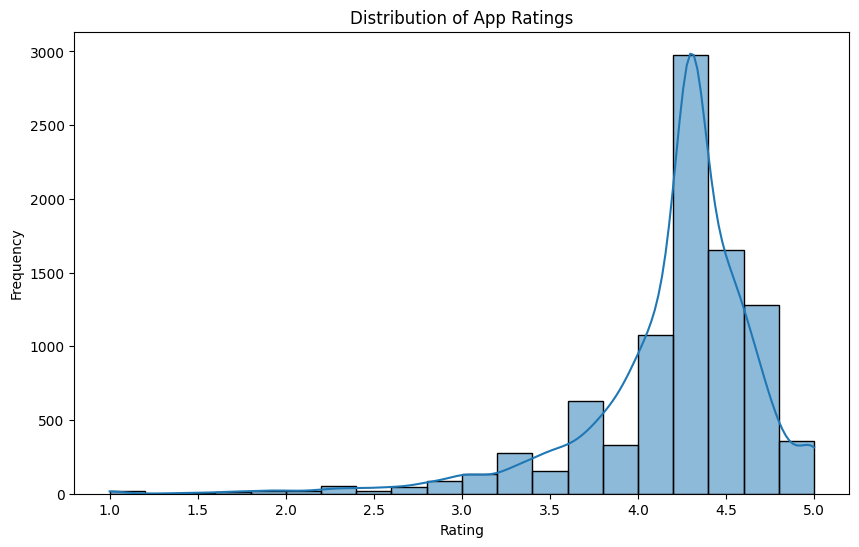

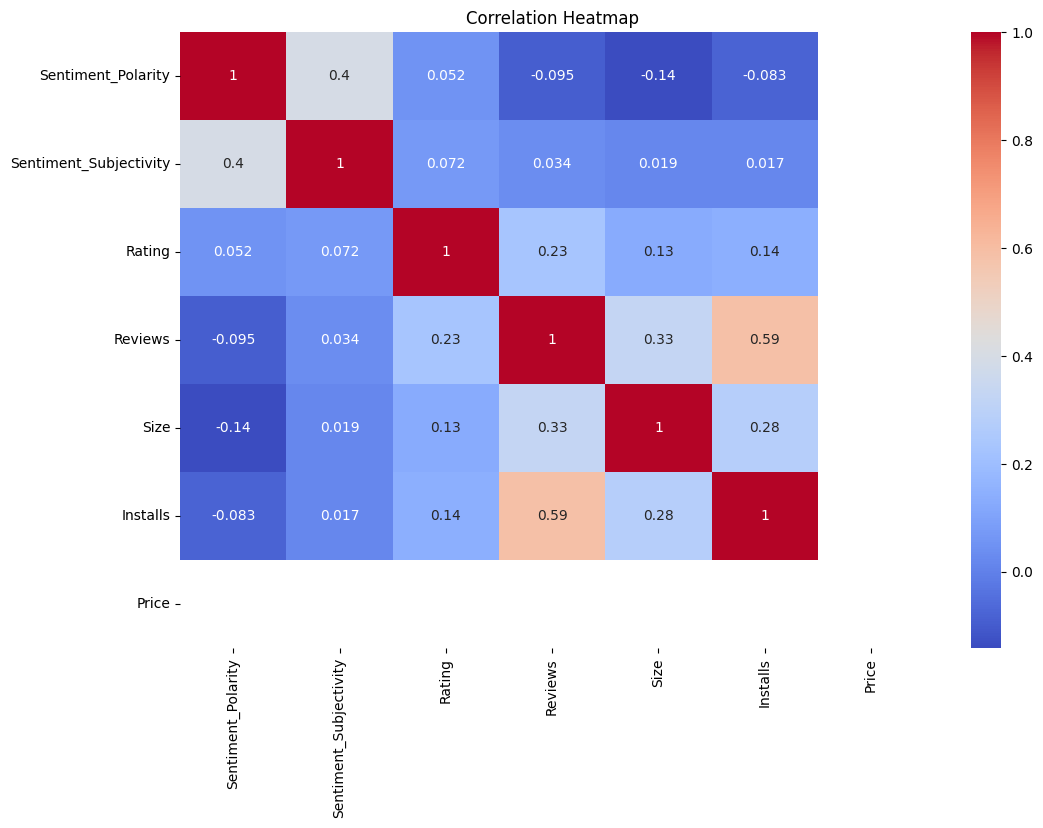

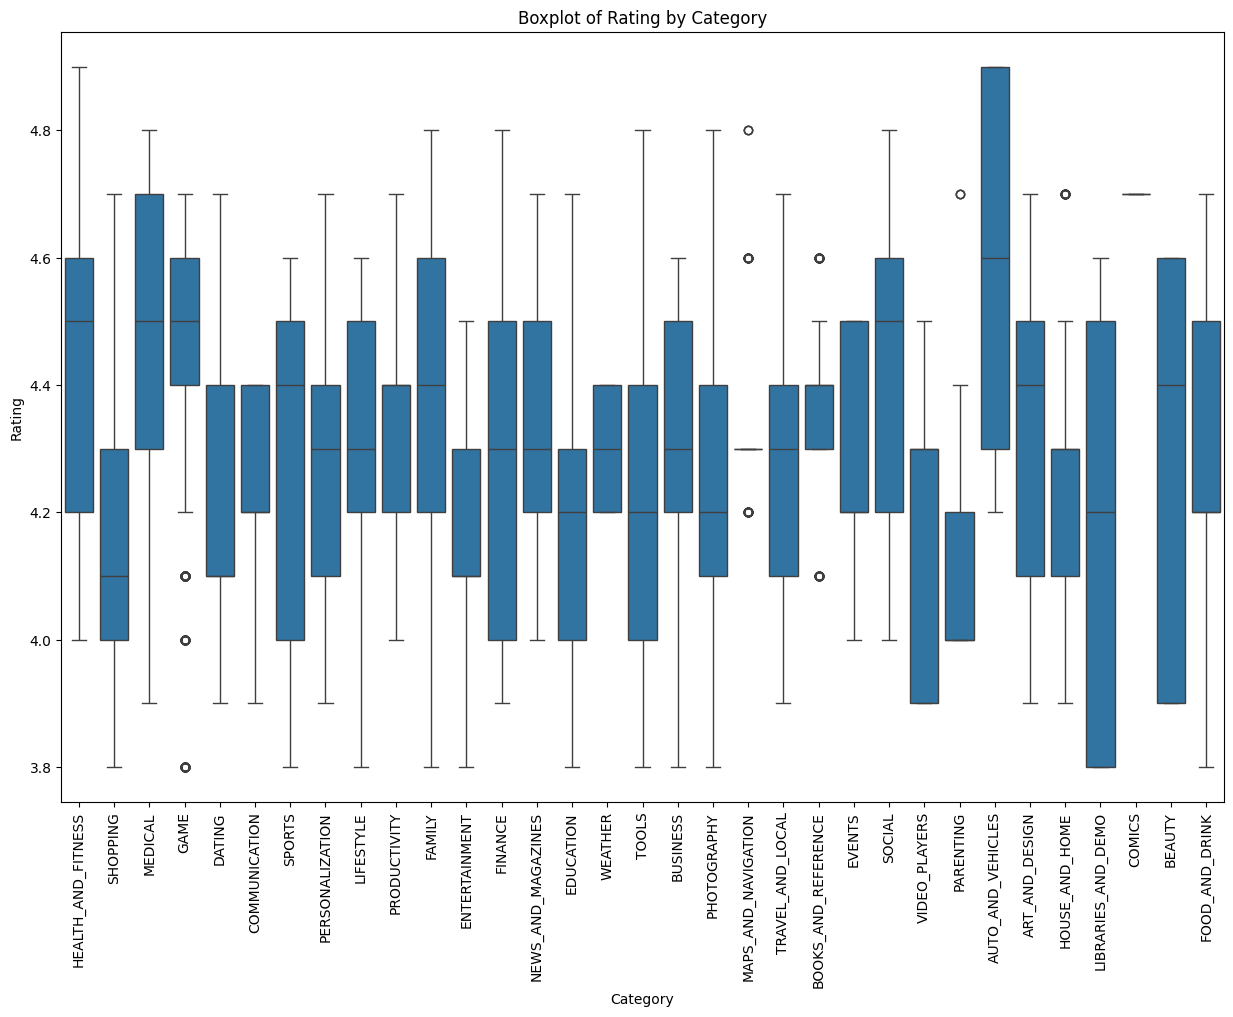

Final Data Overview:
    Rating  Reviews      Size  Installs  Price  Sentiment_Polarity  \
0 -1.31909 -0.50326 -0.947023 -0.828316    0.0            2.293153   
1 -1.31909 -0.50326 -0.947023 -0.828316    0.0            0.060456   
2 -1.31909 -0.50326 -0.947023 -0.828316    0.0            0.506995   
3 -1.31909 -0.50326 -0.947023 -0.828316    0.0            2.293153   
4 -1.31909 -0.50326 -0.947023 -0.828316    0.0            2.293153   

   Sentiment_Subjectivity  Category  Type  Content Rating  Genres  
0                0.143525        15     0               2      29  
1               -0.780185        15     0               2      29  
2                1.432365        15     0               2      29  
3               -0.736659        15     0               2      29  
4               -0.736659        15     0               2      29  
Total Missing Values in Final Data:
Rating                    0
Reviews                   0
Size                      0
Installs                  0
Pr

In [16]:
# Step 1: Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from textblob import TextBlob

#Load the Files
user_reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')
app_data_df = pd.read_csv('googleplaystore.csv')

#Check for Missing Values and Clean Data
# Drop rows with missing reviews
user_reviews_df.dropna(subset=['Translated_Review'], inplace=True)

#Fill missing ratings with median
app_data_df['Rating'].fillna(app_data_df['Rating'].median(), inplace=True)

#Drop rows with missing critical categorical data
app_data_df.dropna(subset=['Type', 'Content Rating', 'Android Ver'], inplace=True)

#Fill missing current version with 'Unknown'
app_data_df['Current Ver'].fillna('Unknown', inplace=True)

#Convert Size to numeric values (in MB)
app_data_df['Size'] = app_data_df['Size'].replace('Varies with device', np.nan)
app_data_df['Size'] = app_data_df['Size'].str.replace('M', '').str.replace('k', 'e-3')
app_data_df['Size'] = app_data_df['Size'].astype(float)

#Drop any remaining rows with missing values in 'Size'
app_data_df.dropna(subset=['Size'], inplace=True)

#Convert Reviews and Installs to numeric values
app_data_df['Reviews'] = app_data_df['Reviews'].astype(int)
app_data_df['Installs'] = app_data_df['Installs'].str.replace('+', '').str.replace(',', '').astype(int)

#Encode the Price column
app_data_df['Price'] = app_data_df['Price'].str.replace('$', '').astype(float)

# Perform sentiment analysis on user reviews
user_reviews_df['Sentiment_Polarity'] = user_reviews_df['Translated_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
user_reviews_df['Sentiment_Subjectivity'] = user_reviews_df['Translated_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Step 4: Arrange the Data
# Merge user reviews with app data on the 'App' column
merged_df = pd.merge(user_reviews_df, app_data_df, on='App')

# Drop duplicate columns if any
merged_df.drop_duplicates(inplace=True)

# Handle NaN values again in the merged DataFrame
merged_df.dropna(inplace=True)

# Remove Outliers using IQR
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

numeric_cols = ['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Sentiment_Polarity', 'Sentiment_Subjectivity']
merged_df = remove_outliers(merged_df, numeric_cols)

# Check for any remaining NaNs
print("Total Missing Values after NaN removal and outlier removal:")
print(merged_df.isnull().sum())

# Step 5: Do Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[numeric_cols])

# Convert scaled features back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# Include categorical variables
categorical_vars = merged_df[['Category', 'Type', 'Content Rating', 'Genres']]

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_vars.columns:
    categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])

# Combine scaled features and encoded categorical variables
final_df = pd.concat([scaled_df, categorical_vars.reset_index(drop=True)], axis=1)

# Step 6: Split the Data
X = final_df.drop('Rating', axis=1)
y = final_df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display training and test sets
print("Training Set:")
print(X_train.head())

print("\nTest Set:")
print(X_test.head())

# Perform EDA
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(app_data_df['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()
sns.heatmap(merged_df[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Boxplot of Rating by Category
plt.figure(figsize=(15, 10))
sns.boxplot(x='Category', y='Rating', data=merged_df)
plt.title('Boxplot of Rating by Category')
plt.xticks(rotation=90)
plt.show()

# Final data overview and missing values
print("Final Data Overview:")
print(final_df.head())

print("Total Missing Values in Final Data:")
print(final_df.isnull().sum())

# Print size of original and merged DataFrames
print(f"Original app_data_df size: {app_data_df.shape}")
print(f"Original user_reviews_df size: {user_reviews_df.shape}")
print(f"Merged and cleaned DataFrame size: {merged_df.shape}")
